In [ ]:
import cv2
import torch
import torchvision
from torchvision.transforms import functional as F
import numpy as np

# Initialize the model and load the weights
def load_model(num_classes):
    model = torchvision.models.detection.fasterrcnn_resnet50_fpn(pretrained=True)
    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = torchvision.models.detection.faster_rcnn.FastRCNNPredictor(in_features, num_classes)
    model.eval()
    return model

model = load_model(num_classes=2)  # Modify 'num_classes' to match your trained model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# Helper function for real-time inference on webcam frames
def process_frame(frame):
    # Convert to RGB and transform to tensor
    image_tensor = F.to_tensor(frame).unsqueeze(0).to(device)

    # Perform inference
    with torch.no_grad():
        output = model(image_tensor)[0]  # Model returns a list, take the first element

    return output

# Set up the webcam capture
cap = cv2.VideoCapture(1)  # Use 0 for the default webcam

while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Process frame for object detection
    output = process_frame(frame)

    # Draw bounding boxes and labels on the frame
    for box, score, label in zip(output['boxes'], output['scores'], output['labels']):
        if score >= 0.5:  # Display boxes only above a certain confidence threshold
            x1, y1, x2, y2 = map(int, box)
            cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)
            cv2.putText(frame, f"Class {label}: {score:.2f}", (x1, y1 - 10),
                        cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 2)

    # Show the frame with detections
    cv2.imshow('Object Detection', frame)

    # Press 'q' to exit
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break

# Release resources
cap.release()
cv2.destroyAllWindows()

In [ ]:
from groundingdino.util.inference import load_model, load_image, predict, annotate

def run_dino(dino, image, text_prompt='food', box_threshold=0.4, text_threshold=0.1):
    boxes, logits, phrases = predict(
        model = dino, 
        image = image, 
        caption = text_prompt, 
        box_threshold = box_threshold, 
        text_threshold = text_threshold
    )
    return boxes, logits, phrases

model = load_model('GroundingDINO/groundingdino/config/GroundingDINO_SwinT_OGC.py', 'groundingdino_swint_ogc.pth')

image_source, image = load_image('dog.jpeg')
# boxes, logits, phrases = run_dino(dino, image, text_prompt='dog')

# annotated_frame = annotate(image_source=image_source, boxes=boxes, logits=logits, phrases=phrases)

In [11]:
import requests

import torch
from PIL import Image
from transformers import AutoProcessor, AutoModelForZeroShotObjectDetection

import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle

In [12]:
model_id = "IDEA-Research/grounding-dino-tiny"
device = "mps"

processor = AutoProcessor.from_pretrained(model_id)
model = AutoModelForZeroShotObjectDetection.from_pretrained(model_id).to(device)

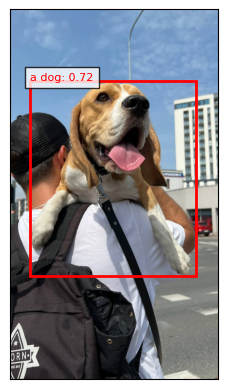

In [20]:
# image_url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image_url = "https://media.roboflow.com/notebooks/examples/dog.jpeg"
image = Image.open(requests.get(image_url, stream=True).raw)
text = "a dog. a person."

inputs = processor(images=image, text=text, return_tensors="pt").to(device)
with torch.no_grad():
    outputs = model(**inputs)

results = processor.post_process_grounded_object_detection(
    outputs,
    inputs.input_ids,
    box_threshold=0.4,
    text_threshold=0.4,
    target_sizes=[image.size[::-1]]
)

fig, ax = plt.subplots(1)
ax.imshow(image)
result = results[0]
for box, label, score in zip(result['boxes'], result['labels'], result['scores']):
    xmin, ymin, xmax, ymax = [int(coord) for coord in box.tolist()]
    rect = Rectangle((xmin, ymin), xmax - xmin, ymax - ymin,
                     linewidth=2, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    ax.text(xmin, ymin, f"{label}: {score:.2f}", 
            bbox=dict(facecolor='white', alpha=0.8),
            fontsize=8, color='r')
    
ax.set_xticks([])   
ax.set_yticks([])

plt.show()